In [43]:
%reload_ext autoreload
%autoreload 2

from time import time
import numpy as np
import keras.backend as k
from keras.layers import Dense, Input, Layer, InputSpec
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
from data import load_data

In [44]:
size = 10000
max_iter = 140
entities = ['ORG', 'GPE', 'PERSON',]#, 'NORP',  ]
x, y, mapping = load_data(size, entity_filter=entities)
n_clusters = len(np.unique(y))
print(x.shape)
assert(n_clusters <= len(entities))

Loading ./data/conll_spacy_10000.pkl
Done: (9920, 772)
{2: 'ORG', 0: 'PERSON', 3: 'GPE'}
Train data balance:
[[   0 3472]
 [   1 2975]
 [   2 3473]]
x: (10419, 768), y: (10419,)
(10419, 768)


In [45]:
def autoencoder_model(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [46]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(x)

In [47]:
metrics.acc(y, y_pred_kmeans)

0.39840675688645744

In [48]:
dims = [x.shape[-1], 500, 500, 2000, 50]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [49]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a 
    vector that represents the probability of the sample belonging to each 
    cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` 
            which represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution.
            Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=k.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning 
                    sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or 
                soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (k.sum(k.square(k.expand_dims(inputs,
                   axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Make sure each sample's 10 values add up to 1.
        q = k.transpose(k.transpose(q) / k.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [50]:
autoencoder, encoder = autoencoder_model(dims, init=init)


In [51]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/jae_weights.h5')

Epoch 1/300
41/41 [==============================] - 1s 8ms/step - loss: 0.1211
Epoch 2/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 3/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0945
Epoch 4/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0945
Epoch 5/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0944
Epoch 6/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0943
Epoch 7/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 8/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0911
Epoch 9/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0888
Epoch 10/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0873
Epoch 11/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 12/300
41/41 [==============================] - 0s 2ms/step - loss: 0.0838
Epoch 13/300
41/41 [=================

In [52]:
autoencoder.load_weights(save_dir+'/jae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

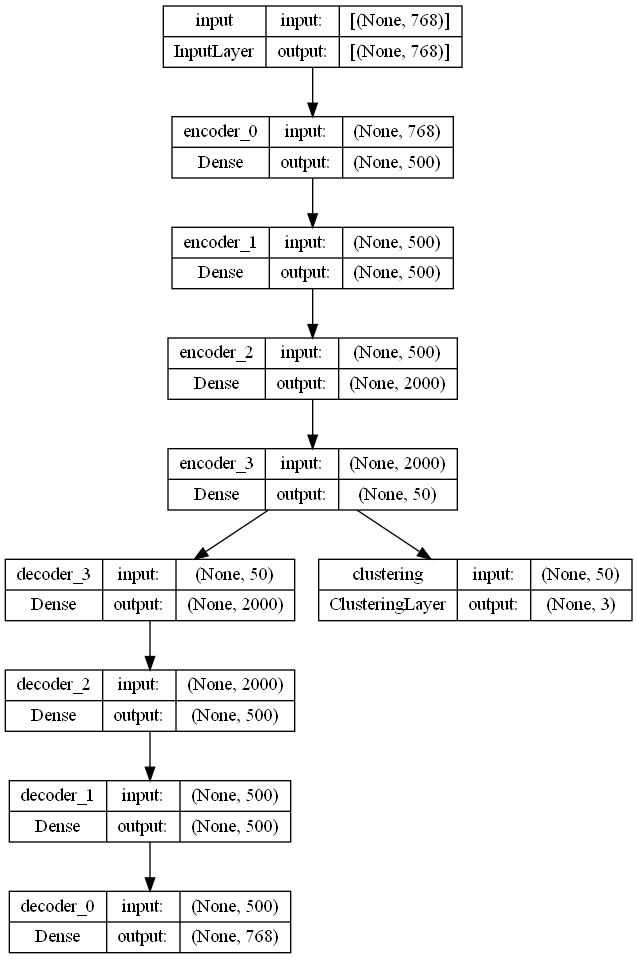

In [53]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [54]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

326/326 [==============================] - 0s 511us/step


In [55]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [56]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

In [57]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [58]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

Iter 0: acc = 0.52951, nmi = 0.09914, ari = 0.11382  ; loss= 0
Iter 140: acc = 0.51492, nmi = 0.08347, ari = 0.08995  ; loss= [0.02863 0.00563 0.02806]
Iter 280: acc = 0.51876, nmi = 0.08498, ari = 0.09343  ; loss= [0.03038 0.0093  0.02945]
Iter 420: acc = 0.52116, nmi = 0.08835, ari = 0.09666  ; loss= [0.03043 0.01956 0.02847]
Iter 560: acc = 0.51368, nmi = 0.08433, ari = 0.08915  ; loss= [0.0476  0.07397 0.0402 ]
Iter 700: acc = 0.51387, nmi = 0.08342, ari = 0.08995  ; loss= [0.03761 0.05301 0.03231]
Iter 840: acc = 0.52068, nmi = 0.08875, ari = 0.09912  ; loss= [0.03712 0.06124 0.03099]
Iter 980: acc = 0.51627, nmi = 0.08531, ari = 0.09399  ; loss= [0.04228 0.05866 0.03641]
Iter 1120: acc = 0.51579, nmi = 0.08507, ari = 0.09353  ; loss= [0.03705 0.0455  0.0325 ]
Iter 1260: acc = 0.51512, nmi = 0.08397, ari = 0.09212  ; loss= [0.04325 0.05555 0.0377 ]
Iter 1400: acc = 0.51579, nmi = 0.08498, ari = 0.09335  ; loss= [0.03699 0.04496 0.0325 ]
Iter 1540: acc = 0.51579, nmi = 0.08507, ari

In [59]:

model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [60]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.51598, nmi = 0.08525, ari = 0.09366  ; loss= [0.02706 0.03756 0.0233 ]


In [61]:
len(np.unique(y_pred))

3

In [62]:
mapping

{2: 'ORG', 0: 'PERSON', 3: 'GPE'}

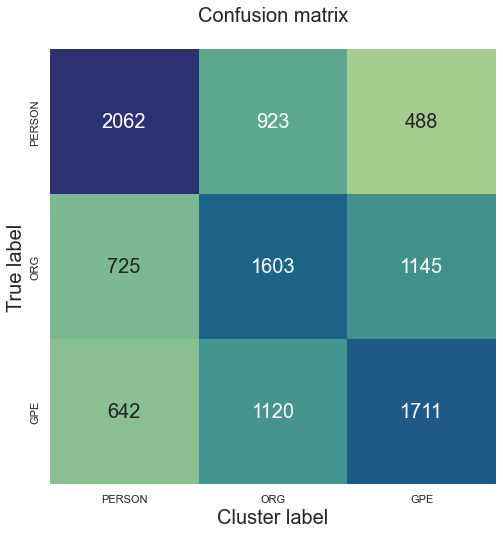

In [63]:
from metrics import plot_confusion
plot_confusion(y, y_pred, mapping, 8)